Soon, Netflix [will be canceling](https://www.npr.org/2023/04/18/1170740799/netflix-ends-dvd-by-mail-service) its DVD-by-mail program, the original service that helped Netflix crush Blockbuster and got us used to watching movies on-demand from the comfort of our homes before streaming was a thing. Perhaps not coincidentally, my dad cancelled my family's subscription to the DVD service this winter. As my brother wisely put it upon hearing my dad’s news, "Netflix can finally stop buying physical DVDs now that their last customer cancelled!"

Of course, when I saw that Netflix had kept my parents' entire DVD history I knew I _had_ to look at the data. According to the history, my family signed up for Netflix in 2004 - that's almost 20 years of DVDs! For most of that time, we were on a plan that let us have 3 DVDs concurrently. At some point while I was in high school, I was given full control over one of the 3 DVDs on our plan. Looking at the DVD history, though, this must have been before Netflix even had the concept of separate accounts - my Netflix account on my family’s plan only shows ~10 DVD rentals, but I distinctly remember years of freedom to discover indie movies and curl up in our game room watching movies on my own in high school. It was such a treat to have my own stream of movies that I had full control over. In fact, I still really miss watching indie movies and discovering other excellent movies from their trailers - Netflix's algorithm really hasn't figured me out as well as those trailers had.

## Getting the data

Anyway, onto the data. When you log in to dvd.netflix.com (a separate website from netlix.com, lol), the history is very simply shown in a table. 

I didn't see any easy way to just export this table, and I didn't really want to try too hard to find a legit way to scrape the site (especially since I figured there'd be complex auth to get around), so I started with the good ol' "inspect page" method. (Actually, I started with copy-paste but that didn't work.) Turns out the information was easily accessible in the html page itself, so I went ahead and just downloaded the html pages for my mom and dad's account histories. My parents started each using their own account to rent DVD's, once the concept of accounts was implemented, and my dad's account had about 500 entries on it so I figured it might have different movies on it.

With a combination of BeautifulSoup's documentation, poking around via Chrome's inspect tool, and good ol' ctrl-F, I was able to pretty easily figure out how to extract all the information I needed.

In [1]:
from bs4 import BeautifulSoup
import pandas as pd

import calmap

import matplotlib.pyplot as plt

In [2]:
def extract_one_movie_info(m):
    """m is a BeautifulSoup object with one movie's row of info"""
    position = m.find('div', 'position').text

    title = m.find('a', 'title').string

    # year, rating, and duration
    meta = m.find('p', 'metadata')
    year, movie_rating, duration = [x.text for x in meta.find_all('span')]

    # get the ratings
    user_rating = m.find('span',  attrs={'data-userrating': True}).attrs['data-userrating']
    avg_rating = m.find('span',  attrs={'data-userrating': True}).attrs['data-rating']

    ship_date = m.find('div', 'shipped').text
    return_date = m.find('div', 'returned').text
    
    return (
        position, 
        {
            'title': title, 
            'year_or_season': year, 
            'movie_rating': movie_rating,
            'disc_or_duration': duration, 
            'user_rating': user_rating,
            'avg_rating': avg_rating,
            'ship_date': ship_date,
            'return_date': return_date
        }
    )
    
def extract_movie_dict(soup):
    """soup is the parsed html containing the full DVD history.
    Returns a dict where the key is the position of the movie (i.e. row number)
    """
    
    # There should only be two tags with these, one with the full table of info and 
    # one with some placeholder code that I'm assuming populates the front-end somehow
    hist = soup.find_all('div', id='historyList')[0]

    # Get all of the movie elements, they're in a <li> </li> blocks woohoo!
    movies = hist.find_all('li', id=True)

    movie_dict = dict([extract_one_movie_info(m) for m in movies])
    
    return movie_dict

In [3]:
with open('DVD Netflix-Alain.html', 'r') as f1:
    soup1 = BeautifulSoup(f1, 'html.parser')

dad_dict = extract_movie_dict(soup1)

with open('DVD Netflix-Nadine.html', 'r') as f2:
    soup2 = BeautifulSoup(f2, 'html.parser')

mom_dict = extract_movie_dict(soup2)

assert len(dad_dict) == 508
assert len(mom_dict) == 1598

In [4]:
# | operator is new in python 3.9: https://docs.python.org/3/library/stdtypes.html#mapping-types-dict
movie_dict = {'mom_' + k: v for k,v in mom_dict.items()} | {'dad_' + k: v for k,v in dad_dict.items()}

# make sure we didn't drop any keys
assert len(movie_dict) == len(dad_dict) + len(mom_dict)

In [5]:
df = pd.DataFrame(movie_dict).T
df.head()

,title,year_or_season,movie_rating,disc_or_duration,user_rating,avg_rating,ship_date,return_date
mom_1,Daughters of the Dust,1991,NR,1h 53m,0,3,12/05/22,Returned 12/29/22
mom_2,I Vitelloni,1953,NR,1h 43m,0,4,11/23/22,Returned 12/05/22
mom_3,Mutiny on the Bounty,1935,NR,2h 12m,0,3.9,11/18/22,Returned 11/23/22
mom_4,The Pervert's Guide to Ideology,2012,NR,2h 16m,0,3.7,10/04/22,Returned 11/17/22
mom_5,Diabolically Yours / The Widow Couderc,1967,NR,3h 2m,0,3.3,09/27/22,Returned 10/04/22


In [6]:
df['user_rating'] = df['user_rating'].astype(float)
df['avg_rating'] = df['avg_rating'].astype(float)

# Some more parsing to get the dates right
df['ship_date'] = pd.to_datetime(df['ship_date'], format='%m/%d/%y')
df['return_date'] = pd.to_datetime(df['return_date'].str.split(' ').str[1], format='%m/%d/%y')

df.head()

,title,year_or_season,movie_rating,disc_or_duration,user_rating,avg_rating,ship_date,return_date
mom_1,Daughters of the Dust,1991,NR,1h 53m,0.0,3.0,2022-12-05,2022-12-29
mom_2,I Vitelloni,1953,NR,1h 43m,0.0,4.0,2022-11-23,2022-12-05
mom_3,Mutiny on the Bounty,1935,NR,2h 12m,0.0,3.9,2022-11-18,2022-11-23
mom_4,The Pervert's Guide to Ideology,2012,NR,2h 16m,0.0,3.7,2022-10-04,2022-11-17
mom_5,Diabolically Yours / The Widow Couderc,1967,NR,3h 2m,0.0,3.3,2022-09-27,2022-10-04


## How many movies did we rent? (But first: a lot of data cleaning)

First, let's get some summary statistics about how many movies we rented, and if any of those rentals were of movies we had already rented.

But before I can do that, I need to make sure that all the movies in my dataset are unique.

In [7]:
# Are all movies unique?
df.groupby('title').filter(lambda x: len(x['title']) > 1).sort_values(by='title').head(20)

,title,year_or_season,movie_rating,disc_or_duration,user_rating,avg_rating,ship_date,return_date
dad_461,1 Giant Leap,2002,NR,2h 35m,2.0,3.1,2007-10-19,2007-10-30
mom_1296,1 Giant Leap,2002,NR,2h 35m,0.0,3.7,2007-10-19,2007-10-30
dad_463,10 mph,2007,NR,1h 32m,3.0,3.5,2007-10-02,2007-10-10
mom_1300,10 mph,2007,NR,1h 32m,0.0,2.8,2007-10-02,2007-10-10
dad_361,127 Hours,2010,R,1h 34m,3.0,4.2,2011-07-06,2011-07-19
mom_974,127 Hours,2010,R,1h 34m,0.0,3.8,2011-07-06,2011-07-19
dad_68,1917,2019,R,1h 59m,0.0,4.7,2020-09-22,2020-10-07
mom_179,1917,2019,R,1h 59m,0.0,4.3,2020-09-22,2020-10-07
dad_221,45 Years,2015,R,1h 35m,5.0,3.8,2016-07-18,2016-08-02
mom_571,45 Years,2015,R,1h 35m,0.0,3.4,2016-07-18,2016-08-02


Answer: definitely not.

Looks ike there are two ways for a movie to be duplicated: (1) it's part of a TV series collection, or (2) it shows up on both mom and dad's histories. For #2, I initially thought it would only be when they both rated the movie differently, but you can see above that there's one example ("A Bad Moms Christmas") where neither of them rated it, but for some reason they have difffferent average ratings. It's very possible that my assumption of what the "data-rating" field means is wrong (maybe it's the average rating for the type of user they've categorized each acount in?), or perhaps there's something about when the data was last updated (though that would be strange because I downloaded both of these histories on the same day).

Anyway, let's keep going and worry about figuring out the ratings later, if at all. For now, it looks like what I care about as a unique rental is a unique combination of title and "duration" column. Did we ever rent the same movie twice?

In [8]:
df.groupby(['title', 'disc_or_duration']).filter(
    lambda x: len(x['ship_date'].unique()) > 1
).sort_values(by=['title', 'disc_or_duration']).head(20)


,title,year_or_season,movie_rating,disc_or_duration,user_rating,avg_rating,ship_date,return_date
mom_667,A Most Wanted Man,2014,R,2h 1m,0.0,3.9,2015-05-05,2015-05-12
mom_693,A Most Wanted Man,2014,R,2h 1m,0.0,3.9,2015-01-21,2015-02-02
dad_262,A Most Wanted Man,2014,R,2h 1m,4.0,4.2,2015-01-21,2015-02-02
mom_797,Anchorman: The Legend of Ron Burgundy,2004,UR,1h 34m,2.0,2.4,2013-08-20,2013-08-24
mom_1382,Anchorman: The Legend of Ron Burgundy,2004,UR,1h 34m,2.0,2.4,2006-11-27,2006-12-05
dad_297,Anchorman: The Legend of Ron Burgundy,2004,UR,1h 34m,2.0,2.9,2013-08-20,2013-08-24
dad_491,Anchorman: The Legend of Ron Burgundy,2004,UR,1h 34m,2.0,2.9,2006-11-27,2006-12-05
mom_175,Awakenings,1990,PG-13,2h 0m,0.0,4.1,2020-10-06,2020-10-15
mom_642,Awakenings,1990,PG-13,2h 0m,0.0,4.1,2015-08-24,2015-09-02
mom_795,Bad Education,2004,NC-17,1h 46m,4.0,4.1,2013-08-24,2013-08-31


Ok, so yes there are definitely movies that were rented multiple times! Interestingly, some of these are duplicated between both mom and dad's accounts but some aren't. I'm assuming this has to do with how Netflix handled the transition between not having accounts, having distinct accounts in the same family plan, and perhaps also how the DVD's were shared across accounts vs. assigned to individual accounts.

I don't really care about those intricacies, since I'm just taking this data as the holistic family plan. Let's get rid of these fake duplicates, and consider coming back later to do some "mom vs. dad" analyses.

Actually, before we move on let's check that the two lists are actually unique...

In [9]:
[k for k in dad_dict if k not in mom_dict]

[]

D'oh! The history I downloaded from my dad's account is a subset of the history in my mom's. So I could have simplified this whole thing by just looking at her history export, though I suppose that would have removed any of the mom vs. dad rating discrepancies. Anyway, I don't care about those so let's get on with the plan.

In [10]:
print(f'With duplicates: {df.shape}, without: {df.drop_duplicates().shape}')
df = df.drop_duplicates()

With duplicates: (2106, 8), without: (2090, 8)


In [11]:
# Ok now how many movies did we rent twice?
print(f"Total rentals = {df[['title', 'year_or_season', 'disc_or_duration', 'ship_date']].drop_duplicates().shape[0]}")

# There must be a way to use transform instead of all these reset_index...
(df[['title', 'year_or_season', 'disc_or_duration', 'ship_date']]
 .drop_duplicates()
 .groupby(['title', 'year_or_season', 'disc_or_duration'])
 .size()
 .reset_index(name='n_rentals')
 ['n_rentals'].value_counts()
).reset_index().sort_values('n_rentals')

Total rentals = 1596


,n_rentals,count
0,1,1441
1,2,76
2,3,1


In total, my parents made a total of 1596 unique rentals. Of these, 1441 were for movies they rented only once. They rented 76 movies twice, and one movie three times. Let's see what the lucky movie was!

In [12]:
(df[['title', 'year_or_season', 'disc_or_duration', 'ship_date']]
 .drop_duplicates()
 .groupby(['title', 'year_or_season', 'disc_or_duration'])
 .filter(lambda x: len(x['title']) >= 3)
)

,title,year_or_season,disc_or_duration,ship_date
mom_312,Before Sunset,2004,1h 20m,2019-04-24
mom_1371,Before Sunset,2004,1h 20m,2007-01-08
mom_1476,Before Sunset,2004,1h 20m,2005-10-25


Looks like it's Before Sunset, which makes sense - it came out in 2004, and was probably a movie that my parents and I both rented separately while I was in high school, and then that I guess my parents re-watched in 2019.

Let's see how big of a gap there was between the two rentals for the movies we rented twice.

Text(0, 0.5, 'Number of movies')

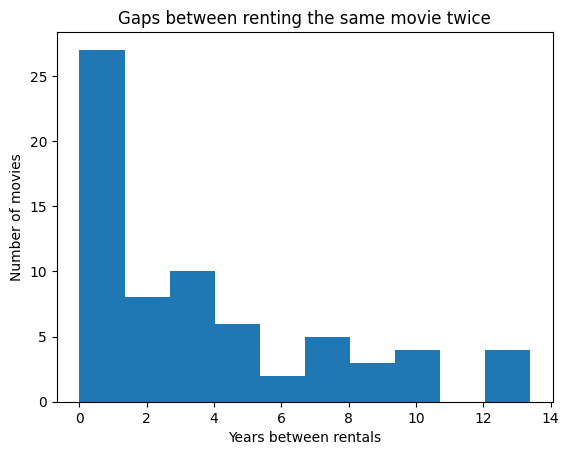

In [13]:
double_rentals = (df[['title', 'year_or_season', 'disc_or_duration', 'ship_date']]
 .drop_duplicates()
 .groupby(['title', 'year_or_season', 'disc_or_duration'])
 .filter(lambda x: len(x['title']) == 2)
)

delta_rental = (
    double_rentals.groupby('title').apply(
        lambda x: x['ship_date'].max() - x['ship_date'].min()
    ).reset_index(name='time_between_rentals')
)

delta_rental['days_between_rentals'] = delta_rental['time_between_rentals'].apply(lambda x: x.days)
delta_rental['years_between_rentals'] = delta_rental['days_between_rentals'] / 365.

ax = delta_rental['years_between_rentals'].plot(kind='hist')
ax.set_title('Gaps between renting the same movie twice')
ax.set_xlabel('Years between rentals')
ax.set_ylabel('Number of movies')

In [14]:
delta_rental.sort_values(by='years_between_rentals', ascending=False)[['title', 'time_between_rentals', 'years_between_rentals']]

,title,time_between_rentals,years_between_rentals
66,Wasabi,4891 days,13.400000
23,Heat,4850 days,13.287671
65,War Dance,4672 days,12.800000
50,The Lady Vanishes,4613 days,12.638356
38,Raise the Red Lantern,3828 days,10.487671
...,...,...,...
55,The Miseducation of Cameron Post,15 days,0.041096
24,Homeland,14 days,0.038356
34,Once Upon a Time in Hollywood,4 days,0.010959
45,The Curious Case of Benjamin Button,1 days,0.002740


In [15]:
df.query('title == "The Curious Case of Benjamin Button"')

,title,year_or_season,movie_rating,disc_or_duration,user_rating,avg_rating,ship_date,return_date
mom_1155,The Curious Case of Benjamin Button,2008,PG-13,2h 46m,4.0,4.0,2009-06-16,2009-06-23
mom_1156,The Curious Case of Benjamin Button,2008,PG-13,2h 46m,4.0,4.0,2009-06-15,2009-06-19
dad_428,The Curious Case of Benjamin Button,2008,PG-13,2h 46m,5.0,4.1,2009-06-16,2009-06-23


There are a handful of movies that we rented twice ten years apart, and some that we rented one day apart! The ones that we rented one day apart might be a fluke, or perhaps they were movies that we had on the waitlist with both of our accounts and didn't coordinate to not duplicate them. That makes sense.

Anyway, now that I understand the data much better, let's dig in some more to all the non-rating-related information.

In [16]:
df = df[['title', 'year_or_season', 'disc_or_duration', 'ship_date', 'return_date']].drop_duplicates()

In [17]:
# first and last movie rental?
# how many movies per month?
# average duration of keeping movies

(df['return_date'].max() - df['ship_date'].min()).days / 365.

18.284931506849315

Wow, we were signed up for Netflix's DVD service for over 18 years! That's pretty amazing, and probably outlasts every commitment my parents made apart from maybe their longest jobs and homes and, oh right, their kids.

1596 rentals over 18 years is a little over 88 movies per year, which is about 1.5 movies per week for 18 years. Considering that we were subscribed to a plan with 3 DVD's for the majority of that time, that's a pretty impressive utilization rate.

Let's see if we can visualize this data nicely. I'll use the return date as a proxy for when the movie was watched, since we were usually pretty prompt about returning the movies after watching them.

_Side note for the folks interested in data wrangling: I realized that I have 1596 unique rentals when considering the ship date, but 1598 unique rows in the data when including the return date for this analysis. It looks like there are two movies with the same ship date but different return dates; I'm assuming that's a bug in Netflix's data, unless my parents and I both rented the same DVD on the exact same day and returned them both exactly three days apart. Given that I've still never seen The Big Sick and don't know what The Harvey Girls is, I'm betting on dirty data._

In [18]:
df.groupby(
    ['title', 'year_or_season', 'disc_or_duration', 'ship_date']
).size().reset_index(name='size').sort_values(by='size')

,title,year_or_season,disc_or_duration,ship_date,size
0,1 Giant Leap,2002,2h 35m,2007-10-19,1
1067,Summer Hours,2008,1h 43m,2015-09-02,1
1066,Suits,Season 1,Disc 1,2012-05-22,1
1065,Suffragette,2015,1h 46m,2016-12-06,1
1064,Stranger than Paradise,1984,1h 29m,2010-09-27,1
...,...,...,...,...,...
525,God Grew Tired of Us,2006,1h 29m,2011-08-23,1
534,GoodFellas,1990,2h 25m,2007-03-12,1
1595,Zero Dark Thirty,2012,2h 37m,2013-04-26,1
1140,The Big Sick,2017,1h 59m,2017-10-24,2


In [19]:
df.query('title == "The Big Sick"')

,title,year_or_season,disc_or_duration,ship_date,return_date
mom_445,The Big Sick,2017,1h 59m,2017-10-24,2017-10-30
mom_446,The Big Sick,2017,1h 59m,2017-10-24,2017-10-27


In [20]:
df.query('title == "The Harvey Girls"')

,title,year_or_season,disc_or_duration,ship_date,return_date
mom_68,The Harvey Girls,1946,1h 41m,2021-12-13,2021-12-20
mom_69,The Harvey Girls,1946,1h 41m,2021-12-13,2021-12-17


In [21]:
# Remove the extra rows
df = df.drop(['mom_69', 'mom_446'])

Ok, back to your regularly programmed visualization. I did a quick google and stumbled across a library called [calmap](https://pythonhosted.org/calmap/) which seems to make Github-style calendars super easily. Heck yes, let's give it a try!

## 18 years of rentals

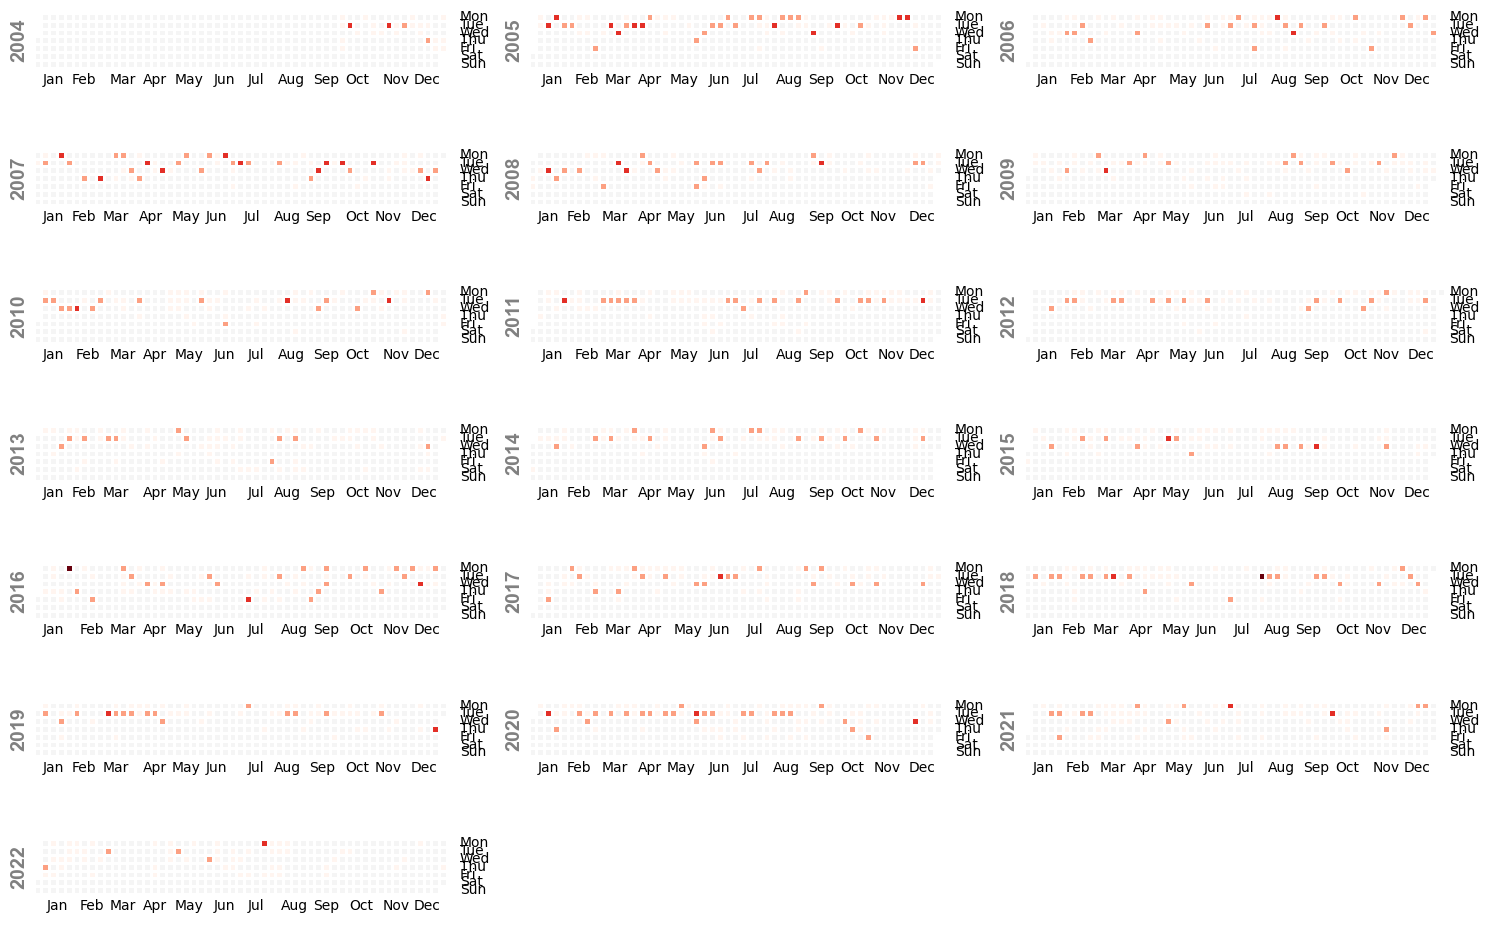

In [22]:
fig, ax = calmap.calendarplot(
    data=df.groupby('return_date').size(), 
    vmin=0, 
    ncols=3,
    fig_kws={'figsize': (15, 10)},
    yearlabel_kws={'fontsize': 14, 'color': 'gray'}
)

### Daily rental patterns

First off, a quick guide to reading this sort of plot (which, despite staring at so many on Github, I've never really understood super well). Each plot shows 365 boxes, where each box is a day. Each row is a day of the week and each column is a week. The boxes are colored by how many DVDs were returned on that day (darker means more DVDs). So if you see a row with lots of filled-in boxes like a horizontal line, that means that we returned DVDs on the same day of the week across multiple weeks. Let's say it's the second row from the top, that would mean that Tuesdays are a frequent return day. Seeing a column of filled-in boxes would mean that we returned DVDs every day on a given week.

Ok, now that we're oriented we can start to pick out some patterns. The first sort of pattern that sticks out to me is about which days we returned the DVDs. First, it looks like we rarely returned movies on two different days per week - you can see that there are very few columns with two filled-in boxes. Second, we never return DVDs on Saturday or Sunday (there are no filled-in boxes in the bottom two rows). It would make sense for Netflix's DVD receiving department to be closed on weekends, so that checks out. Finally, it looks like our most frequent return day is Tuesday -- that makes perfect sense! My parents tend to watch movies over the weekend, which means they would get picked up by USPS on Monday and received by Netflix the following Tuesday.

Another observation is that we would sometimes go months without returning any DVDs - you can see this as areas where there are multiple columns in a row of empty boxes. My guess is that these likely correspond to periods when my parents were on vacation, out of town, or otherwise busy. You can see examples of these gaps in June and July of a handful of years, which is what tipped me off to this vacation hypothesis. But there's a lot of gaps, so I don't think I'll ask them to corroborate this hypothesis with the most recent dates of their big RV trips.

### Return day consistency seems informative

Finally, the consistency of which days of the week we returned DVDs is intriguing - there are some years where it's really consistent (the filled-in boxes are all on the same two-ish rows) and others where it's not. From just looking at the plot, it seems that 2005-2009 didn't have super consistent return days of the week - that makes sense, this was the period where I lived at home and had my own dedicated DVD (before the days of password sharing, this is how we shared accounts!). My guess is that I either watched movies on weekdays sometimes or, more likely, was less prompt at returning them after I watched them, which would explain the variety of return days. 

The following 5 years, 2020-2015, had a much more consistent return day pattern, with most returned on Mondays or Tuesdays. This also makes sense, as this was the period where my parents were both empty nesters but still working: during this time, they would have been more likely to watch movies on the weekend than during the week, thus mailing them back on Mondays and Netflix receiving them on Tuesdays. 

Then 2016 and 2017 are less consistent again - my guess is that this is right around when my mom retired. When I was talking to my parents about this analysis, my mom mentioned that when she first retired she watched a lot of TV series on Netflix DVDs. I also know that it took my parents a while to start paying for all the streaming services, so it would make sense that in these first few years after retirement you see a lot less consistency in the return days, as my mom was likely burning through TV shows via Netflix's DVD service! 

2018 and onwards gets decently consistent again. My hypothesis here is that 2018 is around when my parents started paying for and using streaming services, so they stopped watching as many movies and TV shows on Netflix DVDs. That would leave Netflix DVDs only for the more obscure foreign films or recently released movies not yet available on streaming that they wanted to watch, and everything else would have been watched via streaming. In this scenario, it makes sense that the behavior would revert to a consistent early-week return date: my dad was still working, and so I assume that they watched the movies that they ordered from Netflix on the weekends, and my mom watched other things during the week via streaming services. 

Finally, 2021 and 2022 are slightly less consisetnt and much more sparse than any of the other years. My dad retired in December 2021, which is when my parents started taking a lot of trips in their RV. But I don't think that's what explains the sparseness - my guess is that they switched their plan from 3 DVDs to 1 sometime in 2021, which led to the slow death of their usage of the service.

### Bring in the parents: putting my hypotheses to the test

I texted my parents to see if I could confirm some of these hypotheses. First off, my mom retired in December 2015 -- huzzah, I was right! Pretty cool that you can see her retirement just in the distribution of return days of the week. 

Then, my dad told me that they had access to Netflix’s streaming as soon as it started in 2007, but my mom doesn’t think they started using it regularly until around 2015. My parents also got Apple TV Box in November 2020, which made streaming very easy across the various services. So that doesn’t check out with my “2018 is when they started streaming regularly” hypothesis - something else must have happened in 2018 that got them back to a more consistent DVD viewing pattern. Maybe my mom ran out of TV shows that Netflix had on DVD? 

Finally, they switched to the plan with only 1 DVD in August 2022 - way after the 2021 sparseness started! So it must have gone the other way: their utilization was going down, and so they downgraded their plan.

## Movie quantity over time

Next up, I want to look at a more high-level summary of the amount of movies we watched. My guess is that we watched way more while I was still living at home, and then that it spiked again after my mom retired. I might also guess that my parents watched more movies in 2020 and 2021 during Covid, but I'm not sure if that would be reflect in the number of DVDs since that's also when they were using streaming services.

In [23]:
# Let's look at it monthly
df['return_month'] = pd.to_datetime(df['return_date'].dt.strftime('%Y-%m'))

In [24]:
movies_per_month = df.groupby('return_month').size().reset_index(name='n_movies')
movies_per_month.head()

,return_month,n_movies
0,2004-09-01,3
1,2004-10-01,8
2,2004-11-01,10
3,2004-12-01,10
4,2005-01-01,10


Text(0.5, 0, '')

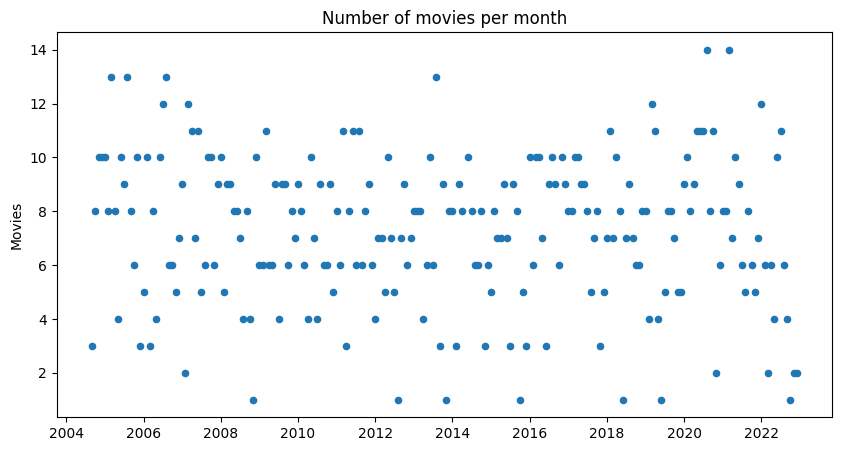

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
movies_per_month.plot(kind='scatter', x='return_month', y='n_movies', ax=ax)

ax.set_title('Number of movies per month')
ax.set_ylabel('Movies')
ax.set_xlabel('')

Welp, nope - doesn't look like there's any discernible pattern in terms of the number of movies we watched over the years. It's very interesting to me that you don't see any obvious decreases when I moved out or even when my parents bumped their plan down to one DVD per month (but maybe that's because there isn't enough data to see that).

I wonder how this compares to the maximum possible number of movies per month. Let's do some back-of-the-envelope math!

Assuming:
- we have a plan that lets us have 3 DVDs at a time
- we can only watch one movie per day
- it takes Netflix one day to process a returned movie and ship out the next one
- they send it with 2 day shipping to get to us
- and when we mail it back, it goes with overnight return shipping

That means that each movie takes up a total of 5 days (1 day to be processed by Netflix + 2 days in the mail to get to us + 1 day to be watched + 1 day to return to Netflix). So each of the 3 DVDs can go through 6 full rental cycles per month, meaning that the max number of movies we could watch in a month is 18. On average, my family watched 7.3 movies per month -- a little less than half of the possible rentals. But there were some months when we went through 14 movies, a 75% utilization rate! For a working family who definitely does not watch movies every day, not bad.

With that, thanks for joining me on this journey down Netflix memory lane! RIP Netflix DVD service, you were a true trailblazer ahead of your times, and those of us who were loyal fans for over 15 years thank you.